*Volcamos los datos a analizar

# ¡¡¡¡fijate bien como dejar lindo el cuaderno!!!!!!


In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

registro = os.path.join(os.getcwd(), "data", "registro_ejemplo.csv")

data_set = pd.read_csv(registro, encoding="utf-8")

data_set

,timestamp,id,evento,usuarie,estado,texto ingresado,respuesta,nivel
0,1.654493e+09,33ff0802-e53f-11ec-8fea-0242ac120002,inicio_partida,sofi,-,-,-,normal
1,1.654633e+09,bd7f4ee8-e53f-11ec-8fea-0242ac120002,intento,sofi,error,Cristiano Ronaldo,Lionel Messi,normal
2,1.654633e+09,6c1bae73-a8d8-4ded-97db-636d59af0ee2,intento,sofi,ok,Lionel Messi,Lionel Messi,normal
3,1.654732e+09,03aea3f6-890c-4194-9613-9c76981083ec,intento,sofi,error,Kylian Mbappé,Alisson,normal
4,1.654742e+09,a1d62ee7-4f35-48a9-9b3e-4fa2f04a6645,intento,sofi,timeout,-,Alisson,normal
5,1.654483e+09,5fb49e99-53a9-48b1-b103-ecbeae12f581,fin,sofi,finalizada,-,-,normal
6,1.654483e+09,5fb49e99-53a9-48b1-b103-ecbeae12f581,fin,sofi,abandonada,-,-,dificil
7,1.654483e+09,5fb49e99-53a9-48b1-b103-ecbeae12f581,fin,leo,error,-,-,facil
8,NaN,5fb49e99-53a9-48b1-b103-ecbeae12f581,fin,señor x,timeout,-,-,normal
9,1.654742e+09,a1d62ee7-4f35-48a9-9b3e-4fa2f04a6645,intento,señor x,timeout,-,Alisson,normal


1) top 10 primeras palabras que se encuentran en las partidas:

#no se me ocurrio una mejor manera, se escuchan sugerencias.

# falta contarlas, pero tambien faltan los datos.

*)primero se saca todos los datos que no importan, luego se itera para sacar el 1er "ok" de cada partida

In [2]:
data_frame = data_set.drop(["timestamp", "id", "usuarie", "texto ingresado", "nivel"], axis="columns")
data_frame = data_frame.drop(data_frame[data_frame.estado == "error"].index)
data_frame = data_frame.drop(data_frame[data_frame.estado == "timeout"].index)
nueva = True
lista_palabras = []

for index, row in data_frame.iterrows():
    if row["evento"] == "inicio_partida":
        nueva = True
    if nueva and row["estado"] == "ok":
        lista_palabras.append(row["respuesta"])
        nueva = False
        
df_new = pd.DataFrame(lista_palabras, columns=["Palabras"])
df_new.groupby("Palabras").size()
#
#
# Testear bien cuando tengamos un registro posta, porque me parece que no termina de funcionar como debe
#
#

Palabras
Lionel Messi    1
dtype: int64

*Aca iria el grafico de partidas finalizadas por esatado

# hay que hacerlo devuelta

# tambien falta como manejamos las inconclusas

# esto no toma las partidas sin evento fin!!!!!!

#posible solucion: iterrows, sacando primero todo lo que no sea inicio o fin de partido

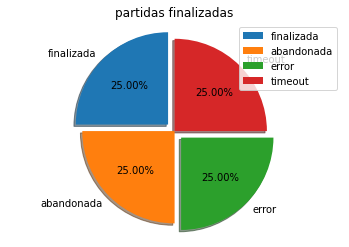

In [80]:
df = data_set[data_set["evento"] == "fin"]
df = df.groupby(["estado"]).size()



etiquetas = ["finalizada", "abandonada", "error", "timeout"]

cant_fin = df["finalizada"]
cant_abandonada = df["abandonada"]
cant_error = df["error"]
cant_time = df["timeout"]

datos_dibujo = [cant_fin, cant_abandonada, cant_error, cant_time]

explode = (0.1, 0, 0.1,  0)

plt.pie(datos_dibujo, explode=explode, labels=etiquetas, autopct='%1.2f%%',
shadow=True, startangle=90, labeldistance= 1.1)

plt.axis('equal')
plt.legend(etiquetas)
plt.title("partidas finalizadas")
plt.show()

#
#
# faltan demasiadas cosas
#
#

*) Grafico de partidas finalizadas segun genero

# 
# hecho

# 

/tmp/ipykernel_10412/1879084317.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["usuarie"] = df["usuarie"].apply(lambda x: usuarios[x][1] if x in usuarios.keys() else "indeterminado")


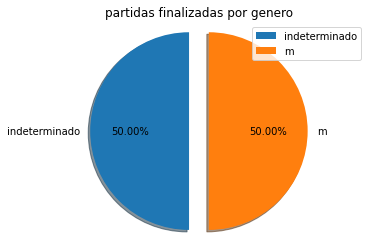

In [81]:
from json import load as jload

jugadores = os.path.join(os.getcwd(), "data", "jugadores.json")

try:
    with open(jugadores, "r", encoding="utf-8") as entrada:
        usuarios = jload(entrada)
except FileNotFoundError:
    usuarios = []

    
df = data_set[data_set["evento"] == "fin"]

# esto tira cartelito rojo
df["usuarie"] = df["usuarie"].apply(lambda x: usuarios[x][1] if x in usuarios.keys() else "indeterminado")
# pero funciona

nuevo = df.groupby(["usuarie"]).size()

etiquetas = nuevo.index.unique()
etiquetas = list(etiquetas)

datos_dibujo = []
for key in etiquetas:
    datos_dibujo.append(nuevo[key])

explode = [(0.1) for x in datos_dibujo]
explode = tuple(explode)

plt.pie(datos_dibujo, explode=explode, labels=etiquetas, autopct='%1.2f%%',
shadow=True, startangle=90, labeldistance= 1.1)

plt.axis('equal')
plt.legend(etiquetas)
plt.title("partidas finalizadas por genero")
plt.show()

#
# imposible saber si esto funciona con el registro completo
#

*) Grafico de las partidas finalizadas segun nivel

# hacible

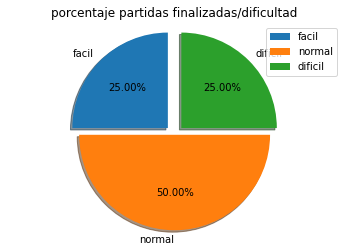

In [82]:
df = data_set[data_set["evento"] == "fin"]
df = df.groupby(["nivel"]).size()

etiquetas = ["facil", "normal", "dificil"]

cant_facil = df["facil"]
cant_normal = df["normal"]
cant_dificil = df["dificil"]

datos_dibujo = [cant_facil, cant_normal, cant_dificil]

explode = (0.1, 0, 0.1)

plt.pie(datos_dibujo, explode=explode, labels=etiquetas, autopct='%1.2f%%',
shadow=True, startangle=90, labeldistance= 1.1)

plt.axis('equal')
plt.legend(etiquetas)
plt.title("porcentaje partidas finalizadas/dificultad")
plt.show()

#
#
# faltan demasiadas cosas
#
#

*) duracion total de la partida

# no se como se calcula en el registro

# tampoco se que pide exactamente la consigna

# de momento, agarra la partida mas larga

# hay que testear una vez que completemos el registro

In [147]:
import datetime

def sacar_tiempo(inicio, fin):
    if inicio > fin:
        respuesta = pd.Timedelta(fin - inicio).total_seconds()
    else:
        respuesta = pd.Timedelta(inicio - fin).total_seconds()
    
    if respuesta > 0:
        return (str(datetime.timedelta(seconds=respuesta)))
    else:
        return (str(datetime.timedelta(seconds=respuesta)))[8:]

df = data_set.drop(data_set[data_set.evento == "intento"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

tempo = 0
partida = True
lista = []

for index, row in df.iterrows():
    if row["evento"] == "inicio_partida":
        tempo = row["timestamp"]
        partida = True
    elif row["evento"] == "fin" and partida:
        lista.append(sacar_tiempo(tempo,row["timestamp"]))
        partida = False
        
lista = map(lambda x: pd.Timedelta(x), lista)
maximo = max(lista)
h = maximo.components[1]
m = maximo.components[2]
s = maximo.components[3]
print(f"La partida mas larga duró: {h} horas, {m} minutos y {s} segundos")


La partida mas larga duró: 21 horas, 11 minutos y 53 segundos


*) tiempo de la respuesta correcta mas rapida

# ni idea como funciona lo del tiempo

# puede que haya que recorrer todo

In [96]:
data_frame = data_set.drop(["id", "usuarie", "texto ingresado", "nivel"], axis="columns")
df = data_frame.drop(data_frame[data_frame.evento == "fin"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

anterior = 0
lista_tiempos = []

for index, row in data_frame.iterrows():
    if anterior and row["estado"] == "ok":
        lista_tiempos.append(pd.Timedelta(row["timestamp"] - anterior).total_seconds()) 
    anterior = row["timestamp"]
    
lista_tiempos

#min(lista)
#faltan datos reales para chequear que funciona

[0.0]

*) promedio de tiempo de respuesta para respuestas correctas

# la vida...

In [ ]:
data_frame = data_set.drop(["id", "usuarie", "texto ingresado", "nivel"], axis="columns")
df = data_frame.drop(data_frame[data_frame.evento == "fin"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

anterior = 0
lista_tiempos = []

for index, row in data_frame.iterrows():
    if anterior and row["estado"] == "ok":
        lista_tiempos.append(pd.Timedelta(row["timestamp"] - anterior).total_seconds()) 
    anterior = row["timestamp"]
    
lista_tiempos

#igual que el anterior, pero sumas todo y dividis por len(lista)
# ...
# creo

*) promedio de tiempo de partida general

# separador

In [ ]:
#igual que el de 2 veces arriba, no entiendo la diferencia conceptual de cada uno
# preguntar en la consulta

*) porcentaje de acierto por usuarie

# necesitaria ampliar el registro_ejemplo para esto

# 

In [3]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
nuevo = df.groupby(["usuarie", "estado"]).size()

for nombre in usuarios:
    if nombre in nuevo and "ok" in nuevo[nombre].keys():
        print("porcentaje de aciertos de {}: {:.2%}".format(nombre, nuevo[nombre].ok / nuevo[nombre].sum()))


#
# hay que pasarlo a porcentaje
#

porcentaje de aciertos de sofi: 25.00%


*) Cantidad de tarjetas para las que el usuarie no dió respuesta (timeout).

# preguntar si es una por usuario, o de un usuario especifico
# (diria yo que es lo primero)

In [214]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
df = df.drop(df[df.estado != "timeout"].index)
df.groupby(["usuarie", "estado"]).size()

for nombre in usuarios:
    if nombre in nuevo:
        print (f"veces que {nombre} no respondió por timeout: {nuevo[nombre].timeout}")

#necesitamos registros mas completos

veces que sofi no respondió por timeout: 1
veces que señor x no respondió por timeout: 1


*) Cantidad de tarjetas en las que el usuarie dió una respuesta errónea.

# lo mismo que el anterior

In [216]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
df = df.drop(df[df.estado != "error"].index)
df.groupby(["usuarie", "estado"]).size()

for nombre in usuarios:
    if nombre in nuevo:
        print (f"veces que {nombre} mandó fruta y le salió mal: {nuevo[nombre].timeout}")


veces que sofi mandó fruta y le salió mal: 1
veces que señor x mandó fruta y le salió mal: 1


opcional_1) Gráfico que muestre el porcentaje de partidas que se juegan para cada día de la
semana.

# ta dificil

opcional_2) Promedio de tiempo de partidas finalizadas por nivel.

# preguntar como se mide el tiempo

opcional_3) Porcentaje de palabras encontradas en las partidas “timeout, es decir que finalizaron
por falta de tiempo para completar.

# mas facil que el primer opcional, parece